# Reversal learning task

Probability ratings will be used to derive both model-free and model-based parameters that will describe the quality of learning

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import pingouin as pg


from glob import glob

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
import warnings
warnings.filterwarnings('ignore')

### get data and age

In [3]:
glober = '/media/Data/Lab_Projects/Aging/behavioral/Reversal/AG_*_RV/ETLearning_*.csv'
db = pd.DataFrame()

for sub in glob(glober):
    temp = pd.read_csv(sub)
    temp['sub']= sub.split("_")[2]
    temp['CSp'] = temp.rectOri[2]
    db = db.append(temp)

print("number of participants with reversal data: ", len(np.unique(db['sub'])))

number of participants with reversal data:  72


In [4]:
age = pd.read_excel('/media/Data/Lab_Projects/Aging/aging_session_log.xlsx', sheet_name='sessions').iloc[:,[0,7,9]]
moca = pd.read_excel('/media/Data/Lab_Projects/Aging/aging_session_log.xlsx', sheet_name='assessments').iloc[:,[0,22]]

age.columns.values[0] = "sub"
moca.columns.values[0] = "sub"
age = age[age.gender != 'gender']
age = age.dropna().reset_index()
age = age.drop(['index'], axis=1)

age = age.merge(moca, left_on='sub', right_on='sub')
age['sub'] = age['sub'].map(lambda x: int(x.lstrip('AG_')))
print("number of participants with age and moca scores: ",age.shape[0])

number of participants with age and moca scores:  63


In [5]:
db['sub'] = db['sub'].astype('int')
db = db.merge(age, left_on='sub', right_on='sub')
db = db[db.moca_score >25]
print('Valid subjects: ', len(np.unique(db['sub'])))

Valid subjects:  47


trials with no response get rating of 0. 

here we replace it with NaN as 0 looks like a very low rating

In [6]:
db['rating_clean'] = db.rating
db['rating_clean'] = db.rating_clean.replace(0, np.nan)
fig1 = db[db.rating!=0]

plot with 0s

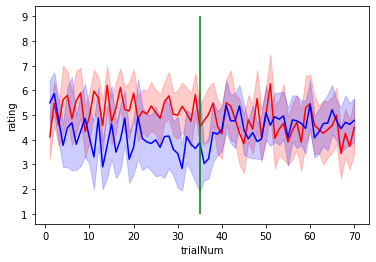

In [7]:
sns.lineplot(x = 'trialNum', y = 'rating', data=db[(db.rectOri == db.CSp)], color = 'red')
sns.lineplot(x = 'trialNum', y = 'rating', data=db[(db.rectOri != db.CSp)], color = 'blue')
plt.vlines(x = 35, ymin = 1, ymax = 9, colors = 'green')

plot without 0s

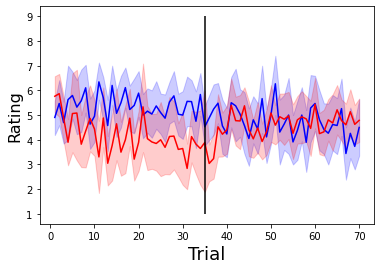

In [8]:
sns.lineplot(x='trialNum',y='rating', data=fig1[(fig1.rectOri==fig1.CSp)], color='blue')
sns.lineplot(x='trialNum',y='rating', data=fig1[(fig1.rectOri!=fig1.CSp)], color='red')
plt.xlabel('Trial', fontsize=18)
plt.ylabel('Rating', fontsize=16)
plt.vlines(x=35, ymin=1, ymax=9, colors='black')

overall disterbution of responses

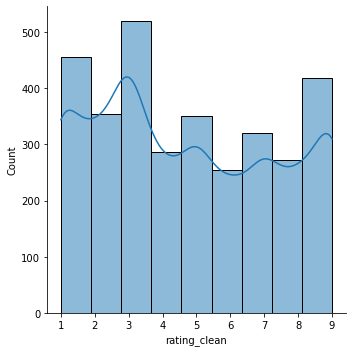

In [9]:
sns.displot(db.rating_clean, kde=True, bins=9)

## Model free analysis

1. Acquisition strength (ACQ) = the difference between the mean ratings of CS+ and CS− in the second half of the acquisition stage (late acquisition)

2. change in rating of CS+ (ΔCS+) between late acquisition and late reversal

3. change in rating of CS- (ΔCS-) between late reversal and late acquisition


In [10]:
subs = db['sub'].unique()

model_free = pd.DataFrame()

for sub in subs:
    df = db[db['sub'] == sub]
    df = df[df.rectValue == 0].reset_index()
    trials = []
    for i in range(len(df)):
    
        temp = df[:i+1]
        trials.append(len(temp[temp['rectOri']== temp['rectOri'][i]]))

    df['trials'] = trials
    
    
    CSaA = np.mean(df[(df['rectOri']==df['CSp']) & (df['trials'] < 15) & (df['trials'] > 7)]['rating_clean'])
    CSbA = np.mean(df[(df['rectOri']!=df['CSp']) & (df['trials'] < 15) & (df['trials'] > 7)]['rating_clean'])
    
    CSaeR = np.mean(df[(df['rectOri']==df['CSp']) & (df['trials'] < 21) & (df['trials'] > 15)]['rating_clean'])
    CSbeR = np.mean(df[(df['rectOri']!=df['CSp']) & (df['trials'] < 21) & (df['trials'] > 15)]['rating_clean'])

    CSaR = np.mean(df[(df['rectOri']==df['CSp']) & (df['trials'] > 21)]['rating_clean'])
    CSbR = np.mean(df[(df['rectOri']!=df['CSp']) & (df['trials'] > 21)]['rating_clean'])

    ACQ = CSaA - CSbA
    dCSa = CSaA - CSaR 
    dCSb = CSbR - CSbA
    
    temp = pd.DataFrame({'sub':[sub], 'ACQ':[ACQ], 'dCSa':[dCSa], 'dCSb':[dCSb], 
                         'age':[df.age[0]], 'CSaeR': [CSaeR], 'CSaR':[CSaR], 
                        'CSbeR':[CSbeR], 'CSbR':[CSbR]})
    model_free = model_free.append(temp)

In [11]:
model_free = model_free.dropna()
print('Model free subjects: ', model_free.shape[0])

Model free subjects:  47


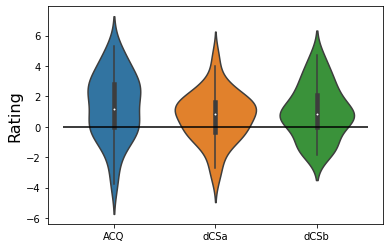

In [12]:
fig2 = pd.melt(model_free, id_vars='sub', value_vars=['ACQ', 'dCSa', 'dCSb'], value_name='score', var_name = 'test')
sns.violinplot(x = 'test', y='score', data=fig2)
plt.xlabel('')
plt.ylabel('Rating', fontsize=16)
plt.hlines(y=0,xmin=-0.5,xmax=2.5, color='black')

In [13]:
pg.ttest(model_free.ACQ, 0)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,4.332891,46,two-sided,0.000079,"[0.73, 1.99]",0.632017,288.905,0.988721


In [14]:
pg.ttest(model_free.dCSa, 0)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.810406,46,two-sided,0.007244,"[0.19, 1.16]",0.40994,5.076,0.785626


In [15]:
pg.ttest(model_free.dCSb, 0)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,3.945222,46,two-sided,0.00027,"[0.49, 1.52]",0.57547,94.338,0.97139


In [16]:
ACQ_cor = sp.stats.pearsonr(model_free.ACQ, model_free.age)
dCSp_cor = sp.stats.pearsonr(model_free.dCSa, model_free.age)
dCSM_cor = sp.stats.pearsonr(model_free.dCSb, model_free.age)

print('ACQ * Age: ', ACQ_cor, 'dCSa * Age: ', dCSp_cor, 'dCSb * Age: ', dCSM_cor)

ACQ * Age:  (-0.20688229358886004, 0.16293471411509075) dCSa * Age:  (-0.32240707446796596, 0.027092516383199688) dCSb * Age:  (-0.16988996221915217, 0.25359246048786593)


[Text(0, 0.5, '')]

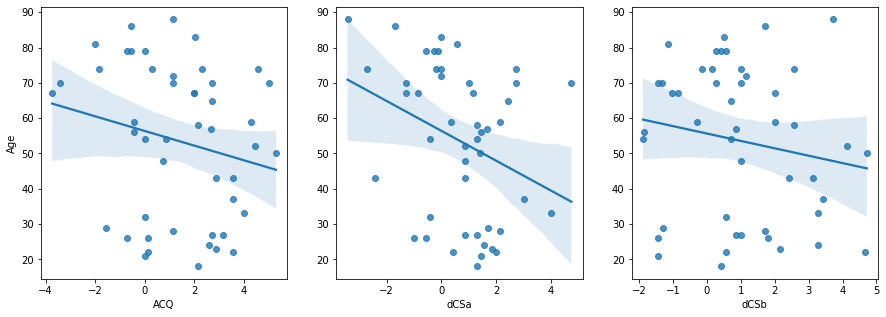

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.regplot(x = 'ACQ',  y = 'age', data=model_free, ax=axes[0])
sns.regplot(x = 'dCSa', y = 'age', data=model_free, ax=axes[1])
sns.regplot(x = 'dCSb', y = 'age', data=model_free, ax=axes[2])
axes[0].set(ylabel='Age')
axes[1].set(ylabel=None)
axes[2].set(ylabel=None)

In [18]:
fig3 = pd.melt(model_free, id_vars=['sub','age'], value_vars=['CSaeR', 'CSaR', 'CSbeR', 'CSbR'], value_name='score', var_name = 'test')

norm = matplotlib.colors.Normalize(vmin=fig3["age"].min(), vmax=fig3["age"].max())
colors = {}
cmap = sns.diverging_palette(240, 10, as_cmap=True )

for cval in fig3["age"]:
    colors.update({cval : cmap(norm(cval))})
    
x = np.arange(0, 10, .5)
y = x

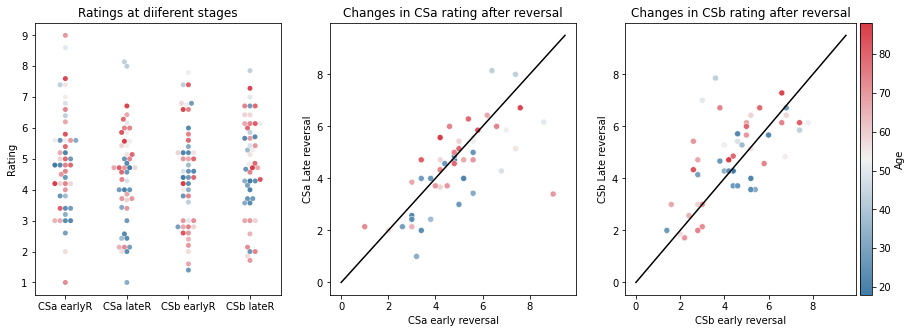

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.swarmplot(x = 'test', y = 'score', hue = 'age', palette = colors, data = fig3, ax=axes[0])
sns.scatterplot(x = 'CSaeR', y = 'CSaR', hue = 'age', palette = colors, data = model_free, ax = axes[1])
sns.scatterplot(x = 'CSbeR', y = 'CSbR', hue = 'age', palette = colors, data = model_free, ax = axes[2])

axes[0].legend_.remove()
axes[0].set(xlabel=None, ylabel='Rating', title='Ratings at diiferent stages', 
            xticklabels=['CSa earlyR','CSa lateR','CSb earlyR','CSb lateR'])

axes[1].set(xlabel='CSa early reversal', ylabel='CSa Late reversal', 
            title='Changes in CSa rating after reversal')
axes[2].set(xlabel='CSb early reversal', ylabel='CSb Late reversal', 
            title='Changes in CSb rating after reversal')

for ax in axes[1:]:
    ax.plot(y, x, color = 'black')
    ax.legend_.remove()
    
## create colorbar ##
divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)
fig.add_axes(ax_cb)
cb1 = matplotlib.colorbar.ColorbarBase(ax_cb, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
cb1.set_label('Age')
plt.show()

In [20]:
model_free.to_csv('data/model_free.csv')